# Propagation

Here is the logic behind how the propagation works.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

import torch.nn.functional as F
from src.utils import *
from src.datatype import *
from src.renderer import *
from tqdm import tqdm

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

In [4]:
patient_id = "000" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
volume = dataset[0]["image"].squeeze(0)

# Setup

s,d corresponds to the source and direction of the transducer. UR will be the class representing the transducer itself.

In [5]:
UR = UltrasoundRenderer(200, 0.1)
s = torch.tensor([128.0, 128.0, 0])
d = torch.tensor([0.0, 0.0, 1.0])

In [6]:
ReflectionLR = UR.simulate_rays(
    volume=volume,
    source=s,
    directions=d,
).unsqueeze(0)

ReflectionLR corresponds to the left-right reflection of the volume. The same can be done for the up-down reflection. 

We use the physics equation obtained from the impednce to compute transmission coefficients left to right and right to left. There are quite some differences between the two.

$$T_{L\rightarrow R} = 1 + \frac{Z_R-Z_L}{Z_R+Z_L}, T_{L\rightarrow R} = 1 + \frac{Z_L-Z_R}{Z_R+Z_L}$$

In [7]:
TransmissionLR = 1 + ReflectionLR
TransmissionRL = 1 - ReflectionLR

Text(0.5, -13, 'Ultrasound Simulation: coefficients for R and T')

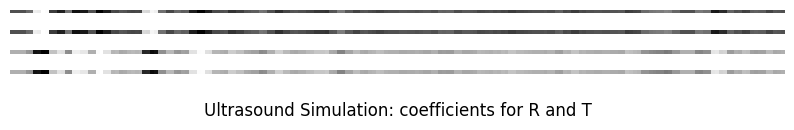

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(10, 1))
for i, row in enumerate([ReflectionLR, TransmissionLR, TransmissionRL, - ReflectionLR]):
    
    ax[i].imshow(row, cmap='gray')
    ax[i].axis('off')

# plt.imshow(torch.stack([Reflection, TransmissionLR, TransmissionRL], dim=0).reshape(3,99))
plt.axis('off')
plt.title("Ultrasound Simulation: coefficients for R and T", y = -13)

In [9]:
def propagate_boundary(g,d,z1,z2):
    refLR = UR.compute_reflection_coeff(z1,z2)
    # assume g and d are postive (so R is absolute)
    traLR = 1 + refLR
    traRL = 1 - refLR
    print(refLR, traLR, traRL)

    new_g = traLR * g + refLR * d
    new_d = traRL * d + refLR * g

    return new_g, new_d

propagate_boundary(
    torch.tensor([10]),
    torch.tensor([10]),
    torch.tensor([1]),
    torch.tensor([2])
)

tensor([0.3333]) tensor([1.3333]) tensor([0.6667])


(tensor([16.6667]), tensor([10.]))

In [10]:
def propagate_full_ray(refLR):
    '''
    Propagate the full ray through the medium using the reflection and transmission coefficients.
    The function assumes that the input is a 1D tensor with shape (1, N), where N is the number of boundaries.
    We propagate using matrix invesion, large N is not recommended.

    The function returns a 2D tensor with shape (2, N), where the first row is the value of left to right ray and the second row is right to left ray.
    '''
    
    N = refLR.shape[1]
    traLR = 1 + refLR
    traRL = 1 - refLR
    refRL = - refLR

    
    matrix = torch.zeros(2*(N+1),2*(N+1), dtype=torch.float32)
    b = torch.zeros(2*(N+1), dtype=torch.float32)

    # BOUNDARY CONDITIONS
    b[0] = 1 # left to right ray
    b[1] = 0 # right to left ray

    matrix[0, 0] = 1 # left to right ray
    matrix[-1, -1] = 1 # right to left ray

    # coupled system:
    # g2 = t12 * g1 - r * d2
    # d1 = r * g2 + t21 * d1
    # need to add boundary by boundary
    for i in range(N):
        # loop through computing all boundaries
        gi = 2*i
        di = 2*i + 1
        gip1 = 2*(i+1)
        dip1 = 2*(i+1) + 1

        # build gip1
        matrix[gip1, gi] = - traLR[0, i-1]
        matrix[gip1, dip1] = -  refLR[0, i-1]
        matrix[gip1, gip1] = 1

        # build dip1
        matrix[di, gi] = - refRL[0, i-1]
        matrix[di, dip1] = - traRL[0, i-1]
        matrix[di, di] = 1
    
    
    
    
    w = torch.linalg.solve(matrix, b)
    
    return w
    
# output = propagate_full_ray(ReflectionLR)

(np.float64(-0.5), np.float64(3.5), np.float64(0.5), np.float64(-0.5))

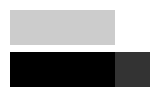

In [11]:
impedances = torch.tensor([1, 1, 2, 2], dtype=torch.float32)  # 4 points
impedances = UR.compute_reflection_coeff(impedances[:-1], impedances[1:]).unsqueeze(0)  # Compute reflection coefficients
w = propagate_full_ray(impedances)

g, d = w[::2], w[1::2]
vmax = max(g.max(), d.max())
vmin = min(g.min(), d.min())
fig, ax = plt.subplots(2, 1, figsize=(10, 1))
ax[0].imshow(g.unsqueeze(0), cmap='gray', vmin=vmin, vmax=vmax)
ax[0].axis('off')
ax[1].imshow(d.unsqueeze(0), cmap='gray', vmin=vmin, vmax=vmax)
ax[1].axis('off')

In [12]:
output = propagate_full_ray(ReflectionLR)
g, d = output[::2], output[1::2];

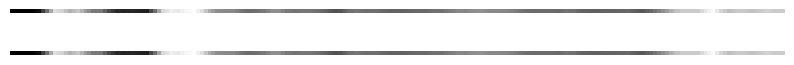

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 1))
for i in range(2):
    ax[i].imshow(output[i::2].unsqueeze(0), cmap='gray')
    ax[i].axis('off')

# conservation des flux


(np.float64(-0.5), np.float64(198.5), np.float64(0.5), np.float64(-0.5))

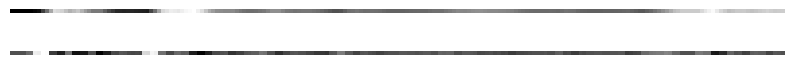

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 1))

ax[0].imshow(output[::2].unsqueeze(0), cmap='gray')
ax[0].axis('off')
ax[1].imshow(ReflectionLR, cmap='gray')
ax[1].axis('off')


# Building a fan

[INFO] Starting from sample index: 50 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 50 torch.Size([200, 201])
Intensity range: 0.0000 to 0.1905


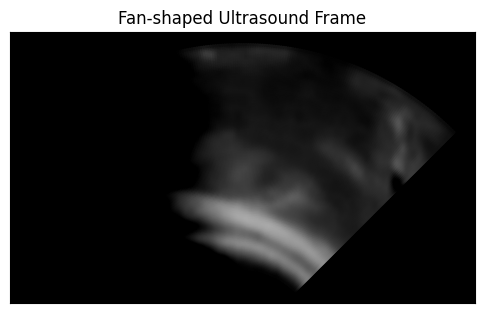

In [16]:
UR = UltrasoundRenderer(200, 0.1)

angle = 20  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

UR.plot_beam_frame(
    volume=volume,
    source=torch.tensor([70,20.,0]),
    directions=torch.tensor(directions),
    angle=45,
    start=50,
);

In [17]:
patient_id = "010" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
volume = dataset[0]["image"].squeeze(0)

In [18]:
UR = UltrasoundRenderer(200, 0.1)

angle = 40  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

100%|██████████| 200/200 [00:02<00:00, 93.83it/s]


Text(0.5, 1.0, 'Fan-shaped Ultrasound Frame (Right)')

<Figure size 600x600 with 0 Axes>

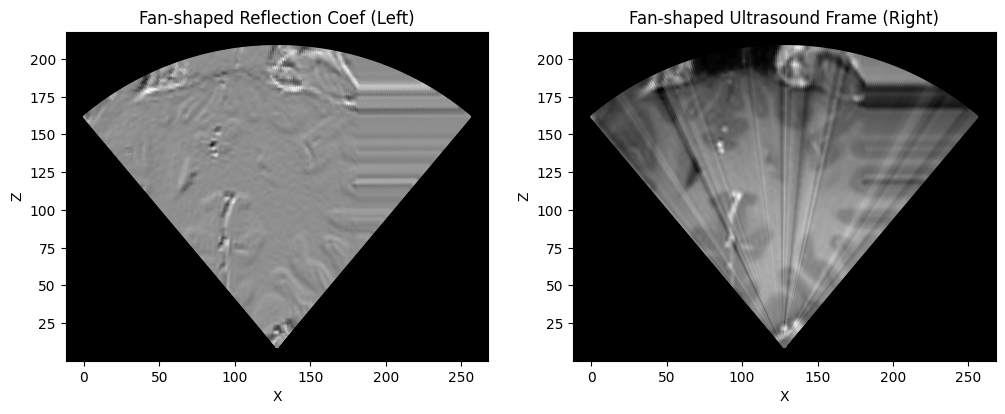

In [19]:
sim_framed = UR.simulate_rays(
    volume=volume,
    source=torch.tensor([200,50.,0]),
    directions=torch.tensor(directions, dtype=torch.float32),
)

attenuation_coeff = 0.0001  # You can tune this number depending on material



# Precompute attenuation factors
depths = torch.arange(UR.num_samples).float()
attenuation = torch.exp(-attenuation_coeff * depths)  # (num_samples,)

frame_np = sim_framed
n_rays, n_samples = frame_np.shape
source = np.array([128, 10])  # (x, z) — assuming 2D for display

processed_output = []
for i in tqdm(range(rays)):
    processed_output.append(propagate_full_ray(frame_np[i:i+1,:])[::2] * attenuation)

processed_output = torch.stack(processed_output, dim=0)
processed_output = processed_output.detach().cpu().numpy()

# Scale ray length to match sample count
ray_len = n_samples
thetas = np.radians(np.linspace(-angle, angle, n_rays))

x_coords = []
z_coords = []
intensities_bmode = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(processed_output[i, r])
        intensities_bmode.append(frame_np[i, r])

# Create scatter plot with intensity
plt.figure(figsize=(6, 6))
plt.rcParams['axes.facecolor'] = 'black'
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(x_coords, z_coords, c=intensities_bmode, cmap='gray', s=3)
ax[0].set_aspect('equal')
ax[0].set_xlabel("X")
ax[0].set_ylabel("Z")
ax[0].set_title("Fan-shaped Reflection Coef (Left)")

ax[1].scatter(x_coords, z_coords, c=intensities, cmap='gray', s=3)
ax[1].set_aspect('equal')
ax[1].set_xlabel("X")
ax[1].set_ylabel("Z")
ax[1].set_title("Fan-shaped Ultrasound Frame (Right)")


In [ ]:
data = iUSDataset(image_path / iUS_file, "iUS", axis=0)

In [ ]:
data.num_slices

256

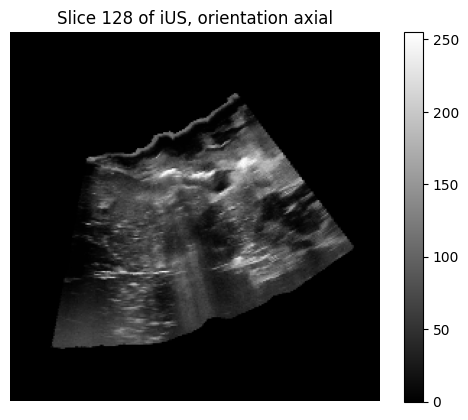

In [ ]:
data.plot2D(128, 0)

# Class usage

Intensity range: 0.0000 to 0.0600


(tensor([[ 0.0129,  0.0236,  0.0361,  ..., -0.0098, -0.0081, -0.0058],
         [ 0.0129,  0.0236,  0.0362,  ..., -0.0117, -0.0096, -0.0069],
         [ 0.0130,  0.0237,  0.0362,  ..., -0.0121, -0.0097, -0.0069],
         ...,
         [ 0.0068,  0.0110,  0.0137,  ..., -0.0132, -0.0107, -0.0075],
         [ 0.0067,  0.0108,  0.0134,  ..., -0.0134, -0.0108, -0.0076],
         [ 0.0066,  0.0106,  0.0131,  ..., -0.0139, -0.0111, -0.0078]]),
 <matplotlib.collections.PathCollection at 0x1df9b2c42c0>)

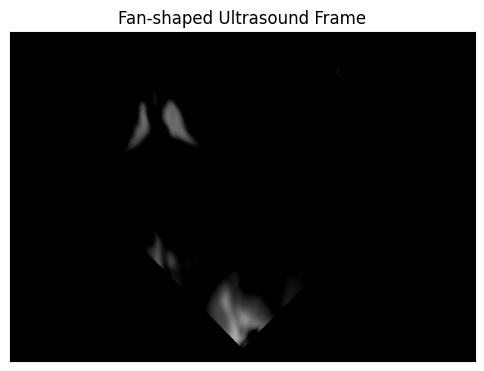

In [ ]:
UR2 = UltrasoundRenderer(150, 0.1)

UR2.plot_beam_frame(
    volume=volume,
    source=torch.tensor([200,70.,0]),
    directions=torch.tensor(directions, dtype=torch.float32),
    angle=45
)

torch.Size([200, 300, 300]) torch.Size([200, 300])
torch.Size([200, 300])


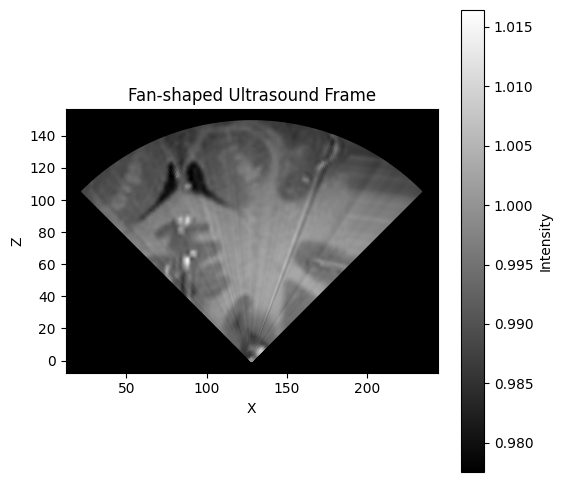

In [28]:
UR2 = UltrasoundRenderer(150, 0.1)

UR2.plot_beam_frame(
    volume=volume,
    source=torch.tensor([200,70.,0]),
    directions=torch.tensor(directions, dtype=torch.float32),
    angle=45
);